# Realized GARCH:
## A joint model for returns and realized measure of volatility
Hansen, P.R., Huang, Z., Shek, H.H. (2012) Journal of Applied Econometrics, 27: 877-906

Application on S&P500 Index

In [1]:
#Libraries
import pandas as pd
import numpy as np

In [2]:
# obtain realized vol form Oxford MAN
filepath="sp500.csv"
data_rg=pd.read_csv(filepath,sep=",",parse_dates=[0],index_col=[0])

In [3]:
data_rg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4001 entries, 2000-01-04 to 2018-03-02
Data columns (total 3 columns):
idx_sp    4001 non-null float64
rk_sp     4001 non-null float64
rt_sp     4001 non-null float64
dtypes: float64(3)
memory usage: 125.0 KB


### Code to estimate GARCH(1,1) from quantopian
<p> Source: Generalized Method of Moments with ARCH and GARCH Models <\p>
<p> By Delaney Granizo-Mackenzie and Andrei Kirilenko developed as part of the Masters of Finance curriculum at MIT Sloan. <\p>
Part of the Quantopian Lecture Series:
* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

In [5]:
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt

## RealGARCH(1,1)
Linear specification given by the following equations:
\begin{equation}
r_{t}=\sqrt{h_{t}}z_{t} \\
h_{t}=\omega + \beta h_{t-1}+ \gamma x_{t-1} \\
x_{t}= \xi + \varphi h_{t}+ \tau_{1}z_{t}+ \tau_{2}(z_{t}^{2}-1) +u_{t}
\end{equation}
where $z_{t} \thicksim (0,1)$ and $u_{t} \thicksim (0,\sigma_{u}^{2})$

## Estimate RealGARCH(1,1)
Use a two step approach since the likelihood han be split up into two components
\begin{equation}
L(\theta)=\frac{-1}{2}\sum_{t=1}^{T} ln(h_{t})+\frac{r_{t}^{2}}{h_{t}}+ln(\sigma_{u}^{2})+\frac{u_{t}^{2}}{\sigma_{u}^{2}} \\
L(r,x; \theta)= \frac{-1}{2}\sum_{t=1}^{T} ln(h_{t})+\frac{r_{t}^{2}}{h_{t}} - \frac{1}{2}\sum_{t=1}^{T} 
ln(\sigma_{u}^{2})+\frac{u_{t}^{2}}{\sigma_{u}^{2}} \\
L(r,x; \theta)= L_{1}(r ; \theta) + L_{2}(x \mid r ;\theta) 
\end{equation}

In [44]:
#Annualized Realized Kernel Variance for S&P 500 index
RV_X=np.sqrt(251)*data_rg.rk_sp.values*1000

In [43]:
#take returns in percentage points S&P 500 index
X=data_rg.rt_sp.values*100

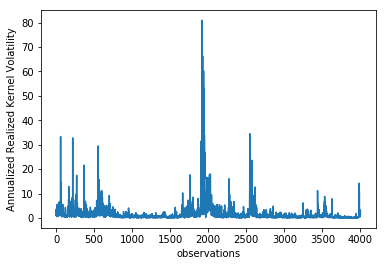

In [12]:
plt.plot(range(len(RV_X)),RV_X)
#plt.hist(RV_X, bins=50)
plt.xlabel('observations')
plt.ylabel('Annualized Realized Kernel Volatility');

### 1. Estimate a GARCH-X(1) model
Estimate
\begin{equation}
r_{t}=\sqrt{h_{t}}z_{t} \\
h_{t}=\omega + \beta h_{t-1}+ \gamma x_{t-1} 
\end{equation}
Extension $h_{t}=\omega + \beta h_{t-1}+ \gamma x_{t-1} +\alpha z_{t-1}^{2}$  

Maximize the likelihood function $L_{1}(r ; \theta)$ given $x_{t}$

In [13]:
# Here's our function to compute the sigmas given the initial guess and observed past realized volatilities
def compute_squared_sigmas_RV(X, RV, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * RV[t-1] + b1 * sigma2[t-1]
    
    return sigma2

In [14]:
#initial sigma
np.mean(RV_X)

1.6821341848969895

In [15]:
sig_rv=compute_squared_sigmas_RV(X, RV_X, np.mean(RV_X), (1, 0.5, 0.5))

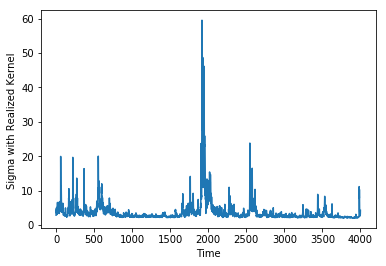

In [16]:
plt.plot(range(len(X)), sig_rv)
plt.xlabel('Time')
plt.ylabel('Sigma with Realized Kernel ');

In [17]:
def negative_log_likelihood_X(X,RV,theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.mean(RV)
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas_RV(X,RV,initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

In [18]:
negative_log_likelihood_X(X,RV_X,(1, 0.5, 0.5))

6619.9815290810902

In [19]:
# Make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood_X, X,RV_X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

C:\cconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


theta MLE: [ 0.02435975  0.46980374  0.45606588]


In [20]:
#fitted sigmas
sigma2_rv_fit = compute_squared_sigmas_RV(X, RV_X, np.mean(RV_X), theta_mle)

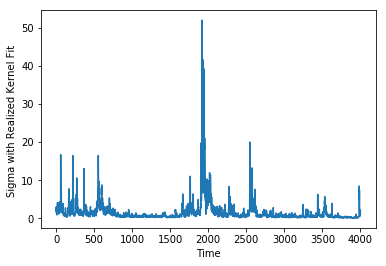

In [21]:
plt.plot(range(len(sigma2_rv_fit)), sigma2_rv_fit)
#plt.hist(sigma2_rv_fit, bins=50)
plt.xlabel('Time')
plt.ylabel('Sigma with Realized Kernel Fit ');

### 2. Estimate Measurement Equation
Likelihood function $L_{2}(x \mid r ;\theta)$ for linear measurement equation given an estimated value for $\{h_{t}\}_{t=1}^{T}$

The maximun likelihood estimator for the measurement equation is equivalent to the OLS estimator of,

\begin{equation}
x_{t}= \xi + \varphi h_{t}+ \tau_{1}z_{t}+ \tau_{2}(z_{t}^{2}-1) +u_{t}, u_{t} \thicksim (0,\sigma_{u}^{2})
\end{equation}

In [22]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [26]:
#obtain estimated residuals and innovations for leverage effects
Z=X/np.sqrt(sigma2_rv_fit)
Z2=(Z**2)-1
#independent variables for OLS
X_=np.matrix([sigma2_rv_fit,Z,Z2]).reshape(3,len(Z)).transpose()

In [27]:
reg.fit(X_,RV_X)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
print("(varphi,tau1,tau2) "+str(reg.coef_))

(varphi,tau1,tau2) [ 0.94906391 -0.18991759  0.2796924 ]


In [32]:
print("xi "+str(reg.intercept_))

xi 0.266552887084


In [33]:
#estimated residuals for measurement equation
ut=RV_X-reg.predict(X_)

In [34]:
sigma_u=np.dot(ut.transpose(),ut)/len(ut)

In [36]:
print("sigma_{u} "+str(sigma_u))

sigma_{u} 6.96916155273


In [37]:
#estimate log likelihood for full model
def negative_log_likelihood_ReGarch(X,RV,theta,sigma_u,ut):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.mean(RV)
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas_RV(X,RV,initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) +
        0.5 * np.log(sigma_u)  +
         (ut[t] ** 2) / (2.0 * sigma_u)
         for t in range(T)]
    )

In [38]:
negative_log_likelihood_ReGarch(X,RV_X,theta_mle,sigma_u,ut)

-627.7515461014325

### 3.  Statistics for Asymetries in the leverage function
Slope of the news impact curve for negative and positive returns
\begin{equation}
\rho^{-}= corr (\tau(z_{t})+u_{t},z_{t} \mid z_{t}<0) 
\end{equation}

\begin{equation}
\rho^{+}= corr (\tau(z_{t})+u_{t},z_{t} \mid z_{t}>0) 
\end{equation}

In [39]:
Lev=reg.coef_[1]*Z+reg.coef_[2]*Z2+ut  

In [40]:
print("Correlation innovations measurement equation "+str(np.corrcoef(Lev,Z)[0,1]))

Correlation innovations measurement equation -0.0964136652468


In [41]:
pL=np.corrcoef(Lev[Z<0],Z[Z<0])
print("Average slope News Impact Curve (negative returns) "+str(pL[0,1]))

Average slope News Impact Curve (negative returns) -0.217290077693


In [42]:
pH=np.corrcoef(Lev[Z>0],Z[Z>0])
print("Average slope News Impact Curve (positive returns) "+str(pH[0,1]))

Average slope News Impact Curve (positive returns) 0.12202591376


### 4. Obtain Standard errors from QMLE sandwich estimator
for parameters from $L_{1}(r ; \theta)$, see paper for equations
\begin{equation}
\sqrt{n}(\hat{\theta}_{n}-\theta) \rightarrow N(0,I_{\theta}^{-1}J_{\theta}I_{\theta}^{-1})  
\end{equation}